## Interesting Visulizations
### Return the top-k interesting visulaizations from any database!
#### Submmitters: Ido Tausi, Afek Nahum

In [157]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import chi2_contingency
from sklearn.preprocessing import LabelEncoder


In [153]:

# Importing the dataset
dataset = pd.read_csv('StudentsDepression.csv')
target_column = 'Depression'

# dataset = pd.read_csv('BillionairesStatistics.csv')

dataset.head()
dataset[target_column].value_counts()

Depression
1    16336
0    11565
Name: count, dtype: int64

In [102]:
def fill_missing_values(dataset):
    for column in dataset.columns:
        # print(f'{column} data type: {dataset[column].dtype}, is_numeric: {pd.api.types.is_numeric_dtype(dataset[column])}')
        if pd.api.types.is_numeric_dtype(dataset[column]):
            dataset.fillna(dataset[column].mean(), inplace=True)

    return dataset

fill_missing_values(dataset)


,Gender,Age,City,Profession,Academic Pressure,Work Pressure,CGPA,Study Satisfaction,Job Satisfaction,Sleep Duration,Dietary Habits,Degree,Have you ever had suicidal thoughts ?,Work/Study Hours,Financial Stress,Family History of Mental Illness,Depression
0,Male,33,Visakhapatnam,Student,5,0,8.97,2,0,5-6 hours,Healthy,B.Pharm,Yes,3,1.0,No,1
1,Female,24,Bangalore,Student,2,0,5.90,5,0,5-6 hours,Moderate,BSc,No,3,2.0,Yes,0
2,Male,31,Srinagar,Student,3,0,7.03,5,0,Less than 5 hours,Healthy,BA,No,9,1.0,Yes,0
3,Female,28,Varanasi,Student,3,0,5.59,2,0,7-8 hours,Moderate,BCA,Yes,4,5.0,Yes,1
4,Female,25,Jaipur,Student,4,0,8.13,3,0,5-6 hours,Moderate,M.Tech,Yes,1,1.0,No,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27896,Female,27,Surat,Student,5,0,5.75,5,0,5-6 hours,Unhealthy,Class 12,Yes,7,1.0,Yes,0
27897,Male,27,Ludhiana,Student,2,0,9.40,3,0,Less than 5 hours,Healthy,MSc,No,0,3.0,Yes,0
27898,Male,31,Faridabad,Student,3,0,6.61,4,0,5-6 hours,Unhealthy,MD,No,12,2.0,No,0
27899,Female,18,Ludhiana,Student,5,0,6.88,2,0,Less than 5 hours,Healthy,Class 12,Yes,10,5.0,No,1


In [103]:
def bin_numerical_columns(dataframe):
    dataframe = dataframe.copy()
    for column in dataframe.columns:
        if pd.api.types.is_numeric_dtype(dataframe[column]):
            if dataframe[column].nunique() < 10:
                continue
            # remove outliers
            q1 = dataframe[column].quantile(0.25)
            q3 = dataframe[column].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            dataframe = dataframe[(dataframe[column] > lower_bound) & (dataframe[column] < upper_bound)]
            # TODO: decide on bins sizes
            bins_number = 10
            dataframe[column] = pd.cut(dataframe[column], bins=bins_number)
    return dataframe


In [164]:
def subset_data(dataframe, column, value):
    return dataframe[dataframe[column] == value]

def create_subsets_for_column(dataframe, column, subset_threshold=10):
    subsets = {}
    for value, count in dataframe[column].value_counts().items():
        # print(f'{value}: {count}')
        if count < subset_threshold:
            continue
        subsets[value] = subset_data(dataframe, column, value)
    return subsets

def create_subsets(dataframe):
    subsets = {}
    for column in dataframe.columns:
        # TODO: calculate subset threshold
        subsets[column] = create_subsets_for_column(dataframe, column)
    return subsets

binned_dataset = bin_numerical_columns(dataset)
subsets_age = create_subsets_for_column(binned_dataset, 'Age')
for key, value in subsets_age.items():
    print(f'{key}: {len(value)}')
    # print(type(value))



# 
# subsets = {
#     "Age": {
#         (18, 20]: dataframe,
#         (20, 22]: dataframe,
#         ...
#     },
#     "CGPA": {
#         (6.5, 7.0]: dataframe,
#         (7.0, 7.5]: dataframe,
#         ...
#     },
#     ...
# }

(17.975, 20.5]: 5381
(25.5, 28.0]: 4749
(30.5, 33.0]: 4581
(20.5, 23.0]: 4530
(23.0, 25.5]: 4041
(28.0, 30.5]: 3095
(33.0, 35.5]: 1477
(35.5, 38.0]: 16


In [198]:

def is_correlated(dataset, column1, column2):
    """
    :param column1: dataframe column of the first feature
    :param column2: dataframe column of the second feature
    :return: chi-square correlation between the two features
    """

    # create a contingency table
    contingency_table = pd.crosstab(dataset[column1], dataset[column2])

    # calculate the chi-square test
    chi2, p, dof, expected = chi2_contingency(contingency_table)

    return chi2, p, dof, expected


def cramers_v(x, y):
    # Ensure inputs are processed properly
    if isinstance(x, pd.Categorical):
        print("hi")
        x = x.codes
    if isinstance(y, pd.Categorical):
        y = y.codes
        print("hi")

    # Create a confusion matrix
    confusion_matrix = pd.crosstab(x, y)

    # Perform chi-square test
    chi2, _, _, _ = chi2_contingency(confusion_matrix)

    # Calculate Cramér's V
    n = confusion_matrix.sum().sum()  # Total number of observations
    r, k = confusion_matrix.shape  # Rows and columns of the matrix
    return np.sqrt(chi2 / (n * (min(r, k) - 1)))

def theils_u(x, y):
    # Convert categorical data to numeric codes
    if isinstance(x, pd.Categorical):
        x = x.codes
    if isinstance(y, pd.Categorical):
        y = y.codes

    # Encode the variables
    le = LabelEncoder()
    x_encoded = le.fit_transform(pd.Series(x).dropna())
    y_encoded = le.fit_transform(pd.Series(y).dropna())
    
    # Joint and marginal probabilities
    joint_prob = pd.crosstab(x_encoded, y_encoded, normalize=True)
    x_prob = joint_prob.sum(axis=1)
    y_prob = joint_prob.sum(axis=0)
    
    # Entropy calculations
    h_x = -np.sum(x_prob * np.log2(x_prob + 1e-9))
    h_xy = -np.sum(joint_prob.values.flatten() * np.log2(joint_prob.values.flatten() + 1e-9))
    
    # Prevent division by zero and ensure positivity
    if h_x <= 0:
        return 0
    return max(0, (h_x - h_xy) / (h_x + 1e-9))

# is_correlated(binned_dataset, 'Age', 'Depression') 
# Calculate Cramér's V
cramers_v_result = cramers_v(binned_dataset['Age'], binned_dataset['Depression'])
print(f"Cramér's V: {cramers_v_result}")

# Calculate Theil's U (optional, for asymmetric association)
theils_u_result = theils_u(binned_dataset['Age'], binned_dataset['Depression'])
print(f"Theil's U (Age -> Depression): {theils_u_result}")


Cramér's V: 0.23566956287125299
Theil's U (Age -> Depression): 0


In [187]:
print(binned_dataset['Age'].head())
print(binned_dataset['Depression'].head())
print(binned_dataset['Depression'].value_counts())


0    (30.5, 33.0]
1    (23.0, 25.5]
2    (30.5, 33.0]
3    (25.5, 28.0]
4    (23.0, 25.5]
Name: Age, dtype: category
Categories (10, interval[float64, right]): [(17.975, 20.5] < (20.5, 23.0] < (23.0, 25.5] < (25.5, 28.0] ... (33.0, 35.5] < (35.5, 38.0] < (38.0, 40.5] < (40.5, 43.0]]
0    1
1    0
2    0
3    1
4    0
Name: Depression, dtype: int64
Depression
1    16330
0    11550
Name: count, dtype: int64


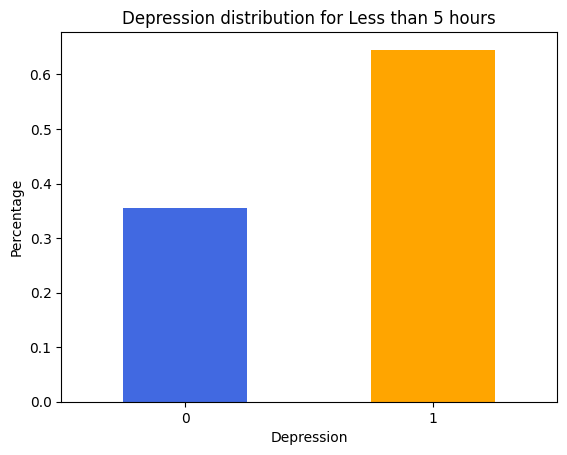

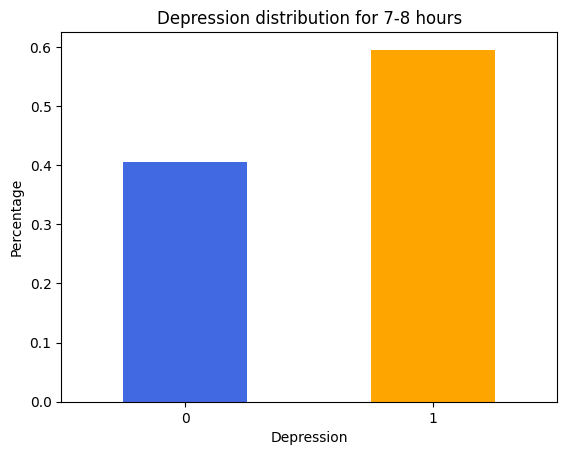

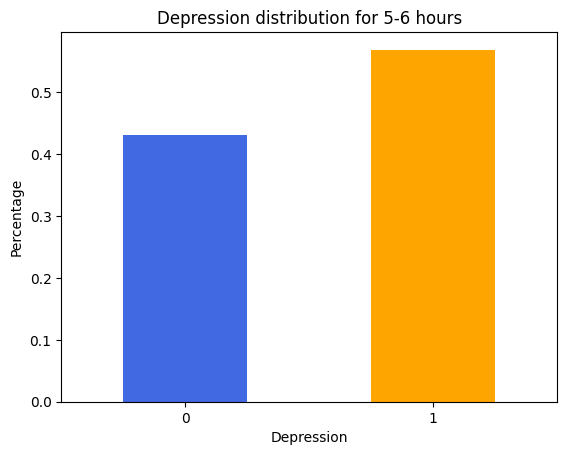

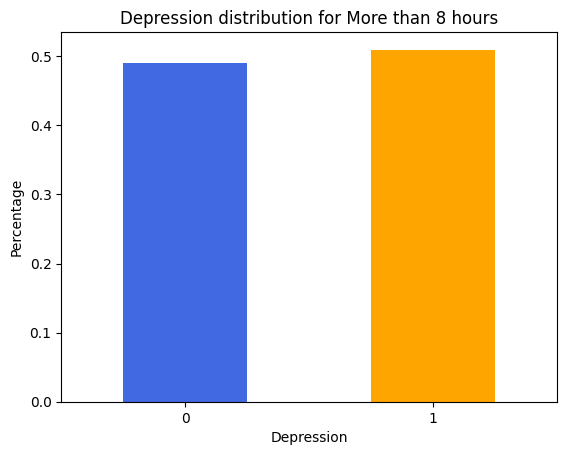

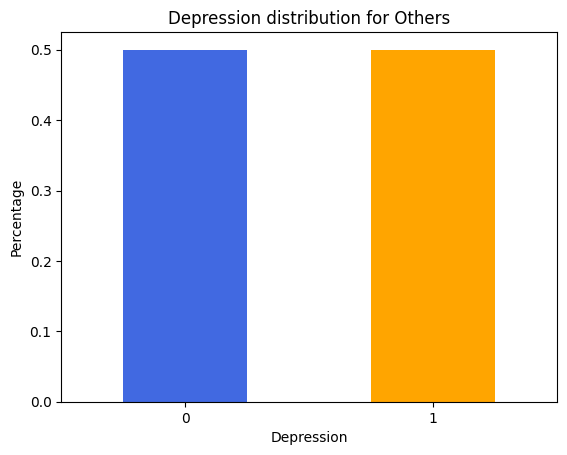

In [155]:
import matplotlib.pyplot as plt

def show_bar_chart_subsets(dataframe, column_subsets, target_column):
    for subset_value, subset_data in column_subsets.items():
        column_to_show = subset_data[target_column]
        
        # Bar chart configuration
        plt.title(f'{target_column} distribution for {subset_value}')
        plt.xlabel(target_column)
        plt.ylabel('Percentage')
        
        # Plot the bar chart
        value_counts = column_to_show.value_counts(normalize=True).sort_index()
        value_counts.plot(kind='bar', color=['royalblue', 'orange'])

        # Set x-ticks to 0 and 1
        rotation = 45
        if pd.api.types.is_numeric_dtype(column_to_show):
            rotation = 0
        plt.xticks(rotation=rotation)

        # Show the plot
        plt.show()

# Example usage
subset_sleep_duration = create_subsets_for_column(binned_dataset, 'Sleep Duration')

show_bar_chart_subsets(binned_dataset, subset_sleep_duration, 'Depression')
